# SSAM_explorer

In [1]:
import os
import pandas as pd
from datetime import datetime, timedelta, date
import glob
from obspy.core import Trace, Stream, UTCDateTime
import sys
sys.path.append('/Users/thompsong/src/icewebPy')
import IceWeb
import numpy as np
from obspy.imaging.cm import viridis_white_r

def read_SSAM_ASCII(SSAMfile):
    error_flag = False
    df = pd.read_table(SSAMfile, header=None, sep='\s+', names=['Date', 'Time', '0', '1', '2', '3', '4', '5', '6', 
                                                     '7', '8', '9', '10', '11', '12', '13',
                                                     '14', '15', '16'])
    try:
        dt = [datetime.strptime(x, "%d-%b-%y") for x in df['Date']]
    except:
        print(df)
        error_flag = True
        return df, error_flag
    hh = [int(x[0:2]) for x in df['Time']]
    mm = [int(x[3:5]) for x in df['Time']]
    td = [timedelta(hours=thishh, minutes=thismm) for thishh, thismm in zip(hh,mm)]
    df.insert(loc=1, column='datetime', value=[t + d for t, d in zip(dt, td)] )
    df.drop(columns=['Date', 'Time'], inplace=True)
    
    #make dates the index
    df.set_index(pd.DatetimeIndex(df['datetime']), inplace=True)
    #fill the gaps
    df = df.resample('1T').mean()
    #fix the Date column
    df['datetime'] = df.index.values 
    
    return df, error_flag

def make_Trace(df, station):
    tr = Trace()
    tr.stats.starttime = df.iloc[0]['datetime']
    tr.stats.station = station
    tr.stats.sampling_rate = 1/60
    cols = df.columns[0:-1]
    df2 = df[cols]
    tr.data = df2.to_numpy().sum(axis=1)
    tr.data[::2]*=-1
    return tr

def make_daily_spectrogram(start_date, outfile):
    YY = start_date.strftime('%y')
    MMM = start_date.strftime('%b').upper()
    DD = start_date.strftime('%d')
    utcdt = UTCDateTime(start_date)    
    obj = IceWeb.icewebSpectrogram()
    SSAMdir = os.path.join(os.getenv('HOME'), 'DATA', 'MVO', "SSAM", "ASCII")    
    matchingSSAMfiles = glob.glob(SSAMdir + '/*/' + DD+MMM+YY+'.DAT')
    st = Stream()
    for SSAMfile in matchingSSAMfiles:
        if 'IRIG' in SSAMfile:
            continue
        df, error_flag = read_SSAM_ASCII(SSAMfile)
        if error_flag:
            continue
        tr = make_Trace(df, SSAMfile.split('/')[-2])
        t = tr.times(reftime=utcdt) 
        thisF = np.arange(17)
        thisS = df[df.columns[0:-1]].to_numpy().transpose()        
        tr.stats['spectraldata'] = {'T':t, 'F':thisF, 'S':thisS}
        st.append(tr)                
    if len(st)>0:
        obj.precomputed = True
        obj.stream = st
        obj.plot(fmin=min(thisF),fmax=max(thisF)+1, equal_scale=True, outfile=outfile, cmap=viridis_white_r, title=utcdt.strftime('MVO analog network %Y %m %d'));
    else:
        print('No data for ',outfile)
    return obj

In [ ]:
start_date = date(1995, 8, 1)
end_date = date(1998, 12, 1)
delta = timedelta(days=1)
while start_date <= end_date:
    print(start_date)
    start_date += delta
    PNGdir = os.path.join(os.getenv('HOME'), 'DATA', 'MVO', "SSAM", "PNG")
    outfile = os.path.join(PNGdir, start_date.strftime('%Y%m%d') + 'sgram.png')
    print(outfile)
    if not os.path.exists(outfile):
        make_daily_spectrogram(start_date, outfile)    

/Users/thompsong/src/icewebPy/IceWeb.py:156: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = fig.add_axes([spectrogramPosition[0], 0.08, spectrogramPosition[2], 0.02])


id=.MGAT.., peakA=2.6e+01, peakf=7.0 Hz(?), bandwidth=(6.0 to 8.0 Hz(?))
id=.MLGT.., peakA=1.5e+01, peakf=7.0 Hz(?), bandwidth=(5.6 to 8.8 Hz(?))


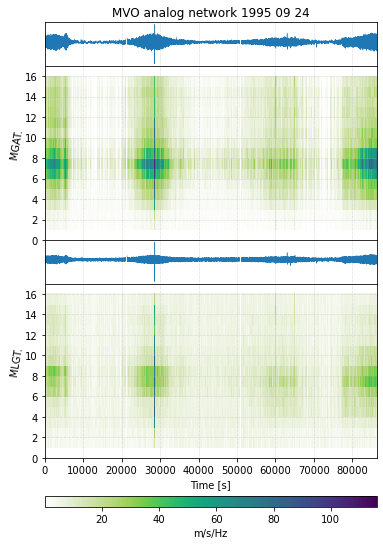

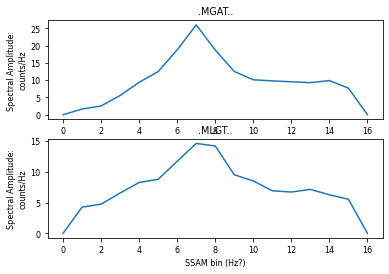

In [2]:
this_date = date(1995,9,24)
obj = make_daily_spectrogram(this_date, 'test.png')
obj.amplitude_spectrum(compute_bandwidth=True)
for tr in obj.stream:
    spd = tr.stats.spectraldata
    print('id=%s, peakA=%.1e, peakf=%.1f Hz(?), bandwidth=(%.1f to %.1f Hz(?))' % ( tr.id, spd.peakA, spd.peakf, spd.bandwidth[0], spd.bandwidth[1]) )    